In [1]:
#导入各种库
import numpy as np
import pandas as pd
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):    
    for filename in filenames:        
        print(os.path.join(dirname, filename))
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#数据预处理
def Data_Culi(data):
    #副本
    data=data.copy()
    
    #获得每个用户的真实票价
    data['Fare']=data['Fare']/data.groupby('Ticket')['Ticket'].transform('count')
    
    #性别男:1,女:2
    map_1={'female':2,'male':1}
    data['Sex']=data['Sex'].map(map_1)
    
    #登船位置处理
    map_2={'C':1,'Q':0.5,'s':1.5}
    data['Embarked']=data['Embarked'].map(map_2)
    data['Embarked']=data['Embarked'].fillna(1)
    
    #对年龄处理,根据Mr,Mrs,Miss,Master预测年龄
    #Mr 成年男子30岁
    data.loc[(data['Age'].isna() & data['Name'].str.contains('Mr. ')),'Age']=30
    #Mrs 已婚女子 25
    data.loc[(data['Age'].isna() & data['Name'].str.contains('Mrs')),'Age']=25
    #Miss 未婚女子 15
    data.loc[(data['Age'].isna() & data['Name'].str.contains('Miss')),'Age']=16
    #Master 小孩哥 16
    data.loc[(data['Age'].isna() & data['Name'].str.contains('Master')),'Age']=16
    #漏网之鱼
    data.loc[(data['Age'].isna() & data['Name']),'Age']=50
    
    #提取Cabin 首字母 作为特征
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'X')
    #把'X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T' 数字化
    map_Cabin={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8,'X':9}
    data['Cabin']=data['Cabin'].map(map_Cabin)

    #亲戚数家人数＋1 把自己也算进去
    data.loc[(data['SibSp']==0),'SibSp']=data['SibSp']+1
    data.loc[(data['Parch']==0),'Parch']=data['SibSp']+1

    #偷偷删掉一些东西
    data=data.drop(labels=["PassengerId","Name","Ticket"],axis=1)
    
    #统一数据类型
    data=data.astype('float32')

    print('数据平均值:\n',data.mean())
    
    return data

In [3]:
from sklearn.preprocessing import StandardScaler
#读取训练集
train_pd=pd.read_csv("/kaggle/input/titanic/train.csv")

#拆分训练集 75%训练 25%组成测试集
from sklearn.model_selection import train_test_split
train_08, test_02 = train_test_split(train_pd, test_size=0.2,  
                                     stratify=train_pd['Survived'])

#处理数据
train_data=Data_Culi(train_08)
test_data=Data_Culi(test_02)

#获取kaggle test测试文件
kaggle=pd.read_csv("/kaggle/input/titanic/test.csv")

#数据处理，标准化
test_kaggle=Data_Culi(kaggle)
test_kaggle.loc[(test_kaggle["Fare"].isna()),"Fare"]=1

#数据标准化
scaler = StandardScaler()
cols=['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
scaler.fit(test_kaggle)
test_kaggle=scaler.transform(test_kaggle)
train_data[cols] = scaler.transform(train_data[cols])
test_data[cols] = scaler.transform(test_data[cols])

#转numpy
train_data=train_data.to_numpy()
test_data=test_data.to_numpy()

数据平均值:
 Survived     0.383427
Pclass       2.313202
Sex          1.345506
Age         29.110842
SibSp        1.205056
Parch        1.918539
Fare        19.244259
Cabin        7.737360
Embarked     0.957163
dtype: float32
数据平均值:
 Survived     0.385475
Pclass       2.290503
Sex          1.379888
Age         28.844973
SibSp        1.206704
Parch        1.955307
Fare        27.432032
Cabin        7.631285
Embarked     0.955307
dtype: float32
数据平均值:
 Pclass       2.265550
Sex          1.363636
Age         29.541866
SibSp        1.124402
Parch        1.971292
Fare        24.177467
Cabin        7.758373
Embarked     0.944976
dtype: float32


In [4]:
#数据加载器
batch_size=40
train_loader=DataLoader(train_data,batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size,shuffle=True)

In [5]:
#神经网络结构
class Neural(nn.Module):
    def __init__(self):
        super().__init__() 
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
            nn.Linear(8,4),
            nn.ELU(),
            #nn.Dropout(p=0.4),
            nn.BatchNorm1d(4),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x=self.flatten(x)
        logits=self.linear_relu_stack(x)
        return logits

In [6]:
#训练方式
def train(train_loader):
    model.train()
    #统计损失
    loss_list=[]
    for batch,X in enumerate(train_loader):
        X=X.to(device)
        x=X[:,1:]
        y=X[:,0].to(device)
        pred=model(x)
        y=y.reshape(len(y),1)
        loss=loss_fn(pred,y)
        #更新梯度
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #统计损失
        loss_list.append(loss.item())
    return sum(loss_list)/len(loss_list)
    

In [7]:
#测试方式
def test(test_loader,accuracy_list,precision_list,recall_list,f1_list):
    model.eval()
    #损失值，目标值,预测值 
    loss_list=[]
    true_label_list = []
    pred_label_list = []
    #关闭梯度
    with torch.no_grad():
        for batch,X in enumerate(test_loader):
            X=X.to(device)
            x=X[:,1:]
            y=X[:,0]
            
            #预测值
            pred=model(x)
            
            #计算损失
            y=y.reshape(len(y),1)
            loss=loss_fn(pred,y)
            
            #损失统计
            loss_list.append(loss.item())
            
            #概率转换为二进制类别
            pred_1=(pred+0.5)//1
            true_label_list.append(y.cpu().detach().numpy())
            pred_label_list.append(pred_1.cpu().detach().numpy())
            
    #计算 准确率 精度 召回 f1
    y_true = np.concatenate(true_label_list)
    y_pred = np.concatenate(pred_label_list)
    accuracy = accuracy_score(y_true,y_pred)
    precision, recall, f1 = precision_recall_fscore_support(y_true,y_pred,average='macro',zero_division=0)[:-1]
    
    #将结果添加至对应列表
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    return sum(loss_list)/len(loss_list)

In [20]:
#定义模型
model=Neural().to(device)

In [21]:
#损失值 准确度 精度 召回 f1
train_loss_list =[]
test_loss_list=[]
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]

In [22]:
#损失函数
loss_fn=nn.BCEWithLogitsLoss()

#优化器
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#迭代次数
epoch=500

#耐心
p=10

for i in range(epoch):
    #学习率调整
    if i >=200 and train_loss_list[-1]<0.64:
        p-=1
        if p == 0:
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
            print("<------学习率，优化器改变------>")
        
    #训练
    train_loss=train(train_loader)
    train_loss_list.append(train_loss)
    
    #测试
    test_loss=test(test_loader,accuracy_list,precision_list,recall_list,f1_list)
    test_loss_list.append(test_loss)
    
    #输出损失
    if (i+1) % 100==0:        
        print(f'------第{1+(i//100) }百次迭代------\n损失值：train:{train_loss_list[-1]}\t test:{test_loss_list[-1]}')
        print(f'精确度：{accuracy_list[-1]}')
        print(f'精度：{precision_list[-1]}')
        print(f'召回：{recall_list[-1]}')
        print(f'f1：{f1_list[-1]}')

------第1百次迭代------
损失值：train:0.6304754416147867	 test:0.615012276172638
精确度：0.8435754189944135
精度：0.873388136686009
召回：0.8052042160737813
f1：0.8214591051581648
------第2百次迭代------
损失值：train:0.6245786415206062	 test:0.6138462781906128
精确度：0.8491620111731844
精度：0.8771469465648856
召回：0.8124505928853756
f1：0.8285987871050112
<------学习率，优化器改变------>
------第3百次迭代------
损失值：train:0.6253368026680417	 test:0.6103847622871399
精确度：0.8491620111731844
精度：0.8771469465648856
召回：0.8124505928853756
f1：0.8285987871050112
------第4百次迭代------
损失值：train:0.6242714722951254	 test:0.619251835346222
精确度：0.8547486033519553
精度：0.8809262166405023
召回：0.8196969696969697
f1：0.8356638418079096
------第5百次迭代------
损失值：train:0.6251565416653951	 test:0.6059767723083496
精确度：0.8547486033519553
精度：0.8809262166405023
召回：0.8196969696969697
f1：0.8356638418079096


<function matplotlib.pyplot.show(close=None, block=None)>

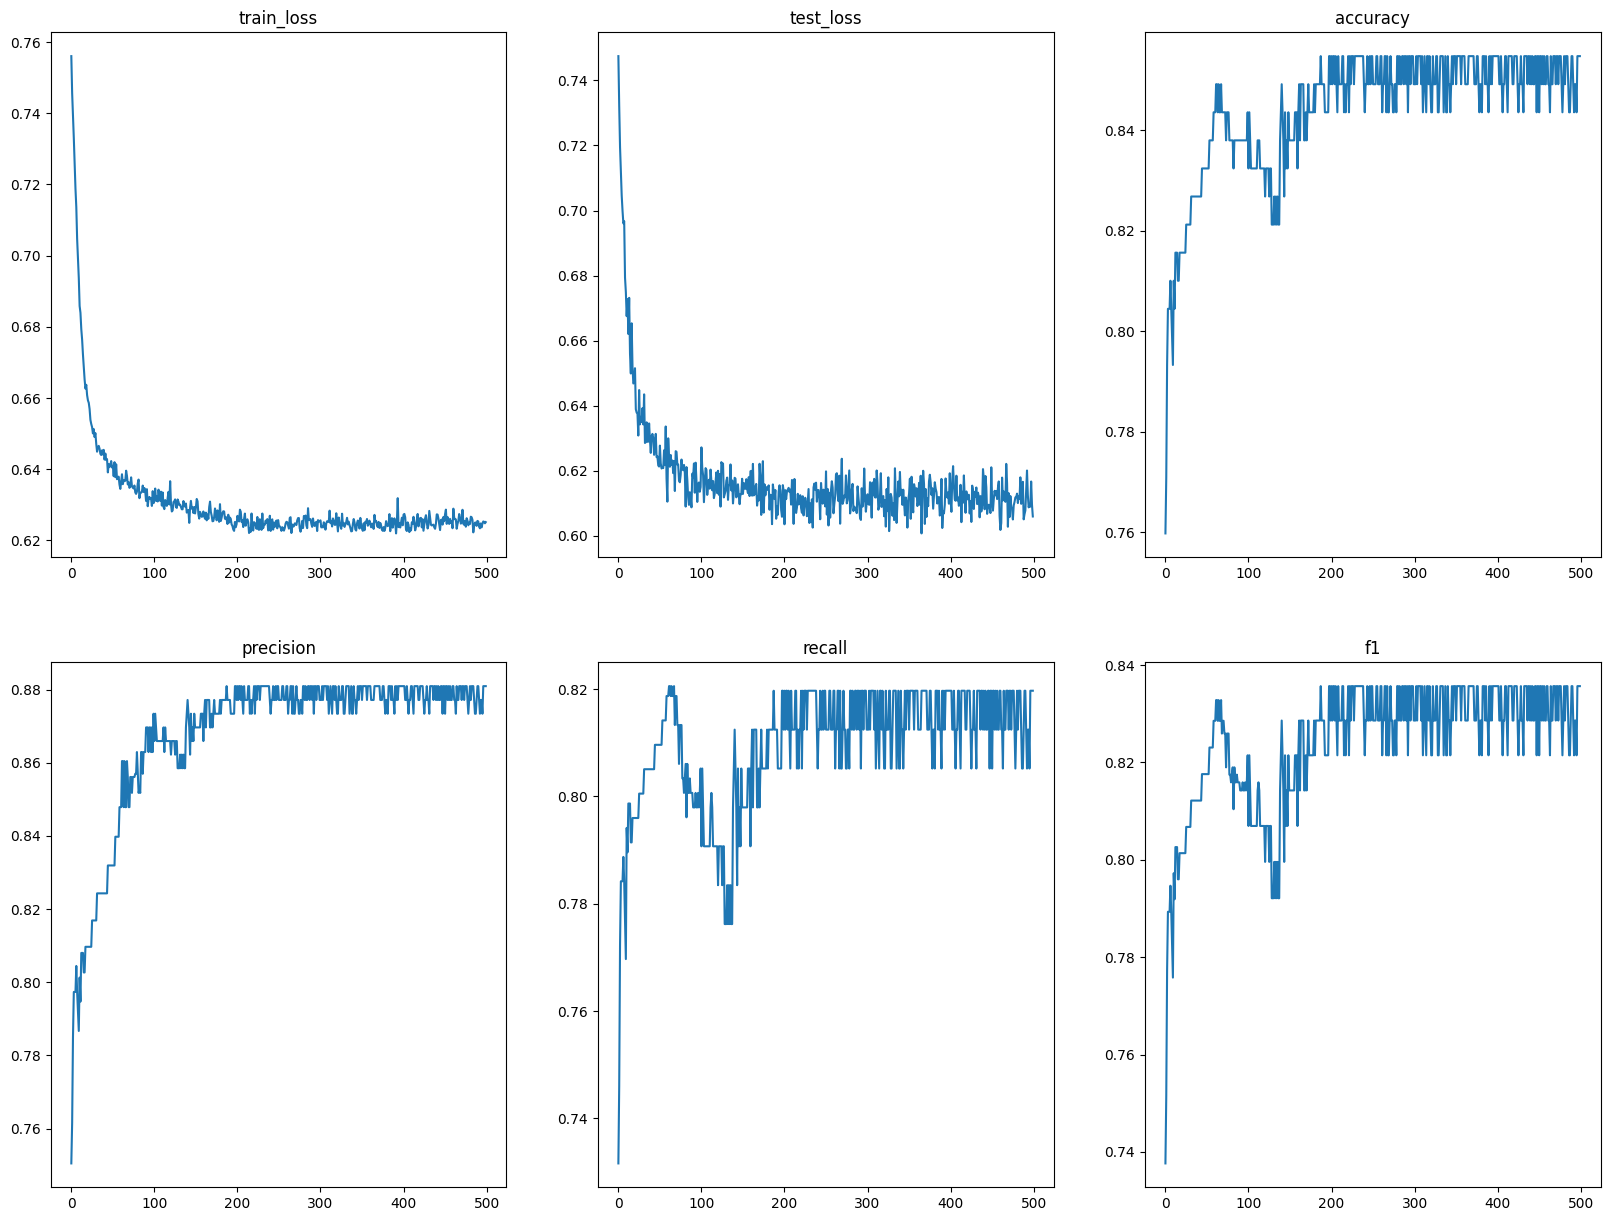

In [23]:
#可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plt.subplot(2,3,1)
plt.plot(train_loss_list)
plt.title("train_loss")
plt.subplot(2,3,2)
plt.plot(test_loss_list)
plt.title("test_loss")
plt.subplot(2,3,3)
plt.plot(accuracy_list)
plt.title("accuracy")
plt.subplot(2,3,4)
plt.plot(precision_list)
plt.title("precision")
plt.subplot(2,3,5)
plt.plot(recall_list)
plt.title("recall")
plt.subplot(2,3,6)
plt.plot(f1_list)
plt.title("f1")
plt.show

In [24]:
#对测试集进行预测

#加载器
kaggle_loader=DataLoader(test_kaggle,batch_size)
#定义测试方法
def test_2(kaggle_loader): 
    model.eval()
    with torch.no_grad():        
        for batch,X in  enumerate(kaggle_loader):
            x=X
            #模型预测
            pred=model(x)
            
            #将预测值二值化
            pred=(pred+0.9)//1
            
            #拼接结果
            if batch==0:
                result= pred                
            else:                
                result=torch.cat([result, pred],dim=0)
                
    #改变运算设备和形状     
    result=result.to('cpu')
    result=result.reshape(len(result))
    
    #获取乘客ID
    ID=kaggle['PassengerId']    

    #数据处理
    df = pd.DataFrame({'PassengerId':ID,
                       'Survived':result})
    df=df.fillna(0)
    df=df.astype(int)

    #不要索的引写入输出文件
    df.to_csv("结果.csv",index=False)
    
    print (df['Survived'].sum())
    print (df.info)
#运行
test_2(kaggle_loader)

128
<bound method DataFrame.info of      PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]>


In [25]:
#获得女性全部存活男性死亡的案例
case=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

#组成测试样本
test_fake=pd.concat([case["Survived"],kaggle],axis=1)

#数据处理，标准化
test_fake=Data_Culi(test_fake)
test_fake.loc[(test_fake["Fare"].isna()),"Fare"]=1
test_fake[cols]=scaler.transform(test_fake[cols])

#检查缺漏
#print(test_fake.isnull().any())

#转numpy
test_fake=test_fake.to_numpy()

#加载器
fake_loader=DataLoader(test_fake,batch_size)

#测式女性存活男性死亡样本
test_loss=test(fake_loader,accuracy_list,precision_list,recall_list,f1_list)
test_loss_list.append(test_loss)
print(f'精确度：{accuracy_list[-1]}')        
print(f'精度：{precision_list[-1]}')        
print(f'召回：{recall_list[-1]}')        
print(f'f1：{f1_list[-1]}')

数据平均值:
 Survived     0.363636
Pclass       2.265550
Sex          1.363636
Age         29.541866
SibSp        1.124402
Parch        1.971292
Fare        24.177467
Cabin        7.758373
Embarked     0.944976
dtype: float32
精确度：0.8755980861244019
精度：0.900974025974026
召回：0.8359962406015038
f1：0.8554671915312391


In [26]:
#测试全部
train_pd=pd.read_csv("/kaggle/input/titanic/train.csv")

#数据处理
train_pd=Data_Culi(train_pd)
train_pd[cols]= scaler.transform(train_pd[cols])
train_pd=train_pd.to_numpy()

#加载器
sum_loader=DataLoader(train_pd,batch_size)

#测试
train_pd=test(sum_loader,accuracy_list,precision_list,recall_list,f1_list)
test_loss_list.append(test_loss)
print(f'精确度：{accuracy_list[-1]}')        
print(f'精度：{precision_list[-1]}')        
print(f'召回：{recall_list[-1]}')        
print(f'f1：{f1_list[-1]}')

数据平均值:
 Survived     0.383838
Pclass       2.308642
Sex          1.352413
Age         29.057430
SibSp        1.205387
Parch        1.925926
Fare        17.788990
Cabin        7.716049
Embarked     0.956790
dtype: float32
精确度：0.8237934904601572
精度：0.8513348548378536
召回：0.7820439075831656
f1：0.797323083119747


In [27]:
#只有男性的样本
train_pd=pd.read_csv("/kaggle/input/titanic/train.csv")
train_man=train_pd[(train_pd['Sex']=='male')]
train_man=Data_Culi(train_man)
train_man[cols]= scaler.transform(train_man[cols])
#加载器
man_loader=DataLoader(train_man,batch_size)
train_pd=test(sum_loader,accuracy_list,precision_list,recall_list,f1_list)
test_loss_list.append(test_loss)
print(f'精确度：{accuracy_list[-1]}')        
print(f'精度：{precision_list[-1]}')        
print(f'召回：{recall_list[-1]}')        
print(f'f1：{f1_list[-1]}')

数据平均值:
 Survived     0.188908
Pclass       2.389948
Sex          1.000000
Age         30.508093
SibSp        1.181976
Parch        1.935875
Fare        20.277256
Cabin        7.939342
Embarked     0.964471
dtype: float32
精确度：0.8237934904601572
精度：0.8513348548378536
召回：0.7820439075831656
f1：0.797323083119747


In [16]:
torch.save(model.state_dict(), '模型.pth')